In [ ]:
!pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=d53f3b02513cfff5fc64a73b859da97fb632e92074b0c6df68186739f31e1cb4
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
Successfully built efficientnet_pytorch


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/Работа/ml/facial-keypoint-detection/data.zip

Archive:  /content/gdrive/MyDrive/Работа/ml/facial-keypoint-detection/data.zip
  inflating: IdLookupTable.csv       
  inflating: SampleSubmission.csv    
  inflating: test.csv                
  inflating: train_15.csv            
  inflating: train_4.csv             
  inflating: training.csv            
  inflating: val_15.csv              
  inflating: val_4.csv               


In [ ]:
#config

import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
BATCH_SIZE = 64
NUM_EPOCHS = 100
NUM_WORKERS = 0
CHECKPOINT_FILE = "b0_15.pth.tar"
PIN_MEMORY = True
SAVE_MODEL = True
LOAD_MODEL = True

# Data augmentation for images
train_transforms = A.Compose(
    [
        A.Resize(width=96, height=96),
        A.Rotate(limit=15, border_mode=cv2.BORDER_CONSTANT, p=0.8),
        A.Affine(shear=15, scale=1.0, mode=0, p=0.2), 
        A.RandomBrightnessContrast(contrast_limit=0.5, brightness_limit=0.5, p=0.2),
        A.OneOf([
            A.GaussNoise(p=0.8),
            A.CLAHE(p=0.8),
            A.ImageCompression(p=0.8),
            A.RandomGamma(p=0.8),
            A.Posterize(p=0.8),
            A.Blur(p=0.8),
        ], p=1.0),
        A.OneOf([
            A.GaussNoise(p=0.8),
            A.CLAHE(p=0.8),
            A.ImageCompression(p=0.8),
            A.RandomGamma(p=0.8),
            A.Posterize(p=0.8),
            A.Blur(p=0.8),
        ], p=1.0),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.2, border_mode=cv2.BORDER_CONSTANT),
        A.Normalize(
            mean=[0.4897, 0.4897, 0.4897],
            std=[0.2330, 0.2330, 0.2330],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False),
)


val_transforms = A.Compose(
    [
        A.Resize(width=96, height=96),
        A.Normalize(
            mean=[0.4897, 0.4897, 0.4897],
            std=[0.2330, 0.2330, 0.2330],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False),
)

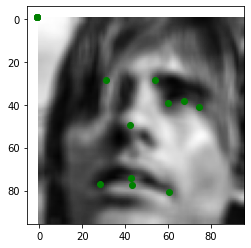

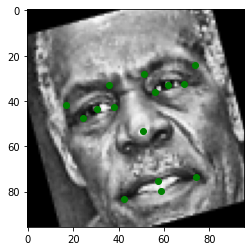

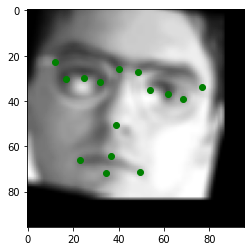

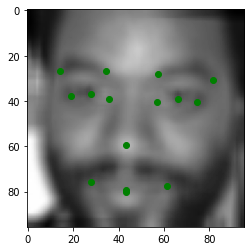

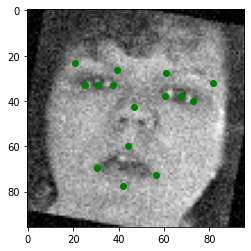

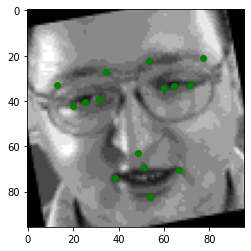

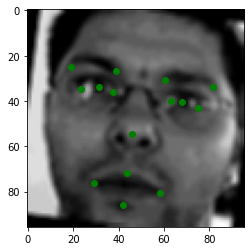

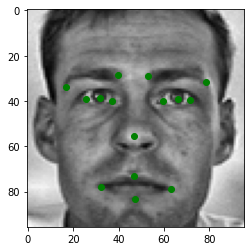

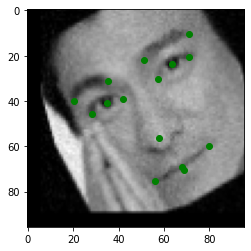

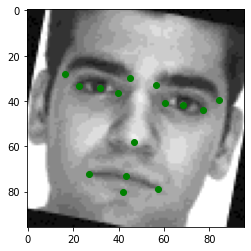

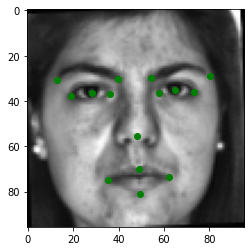

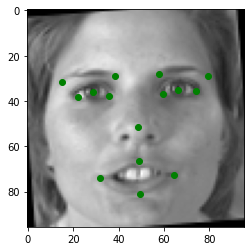

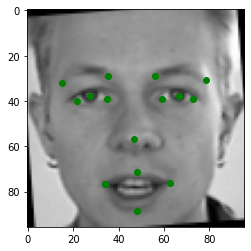

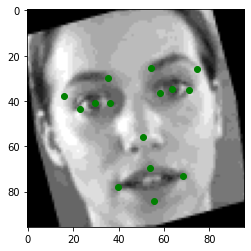

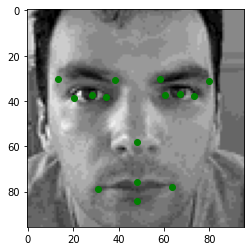

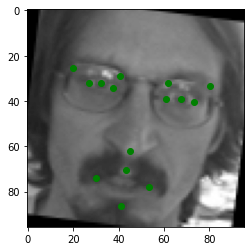

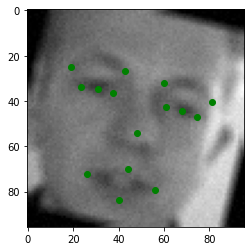

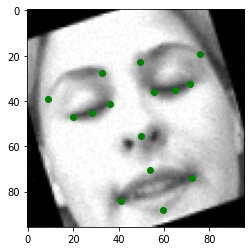

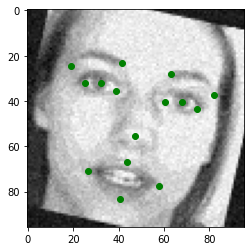

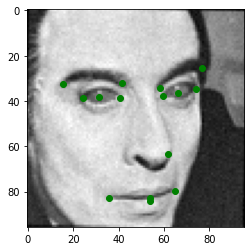

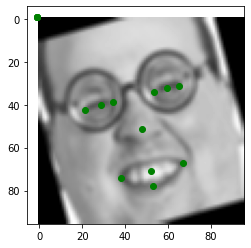

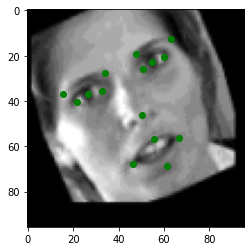

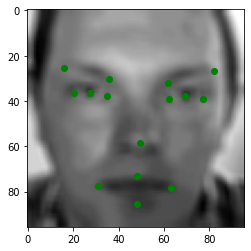

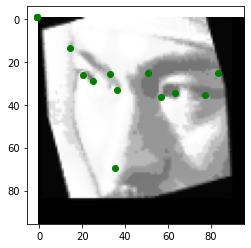

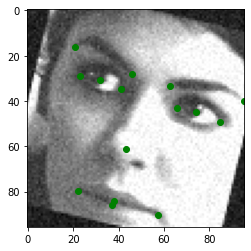

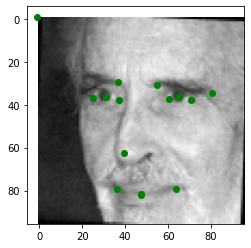

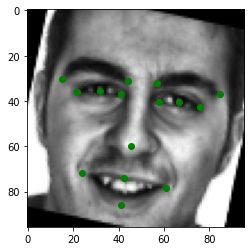

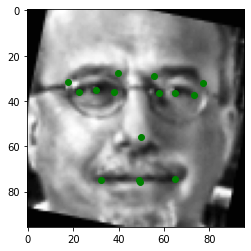

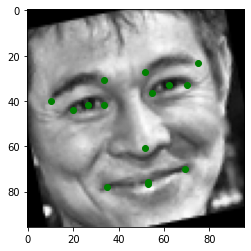

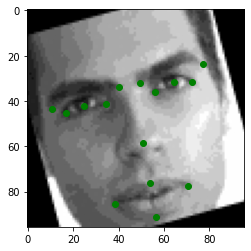

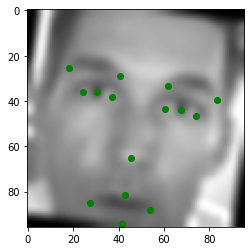

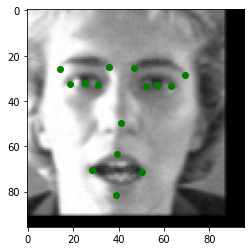

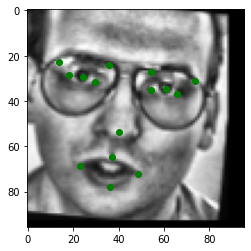

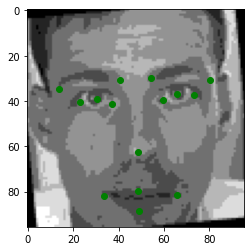

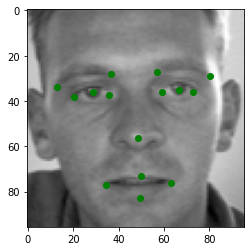

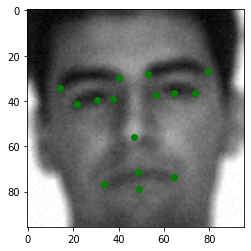

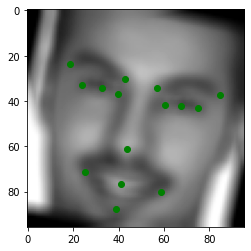

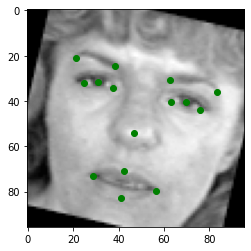

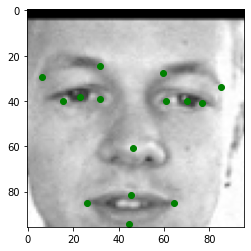

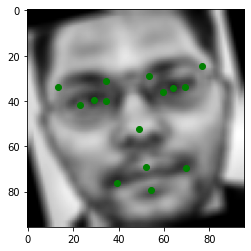

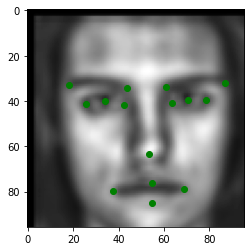

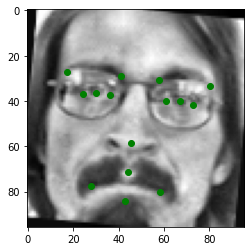

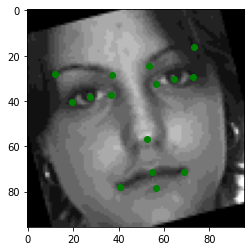

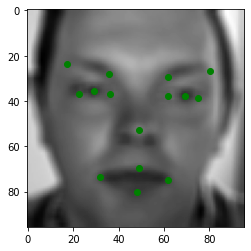

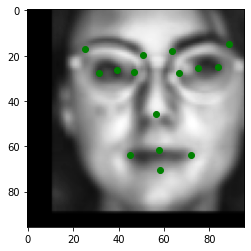

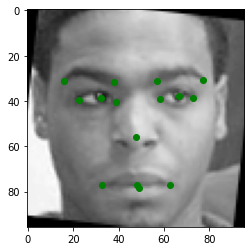

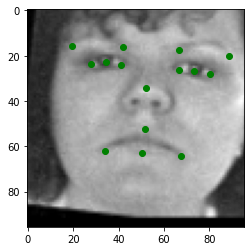

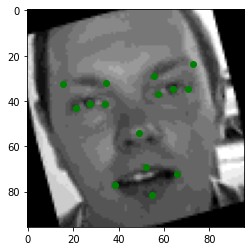

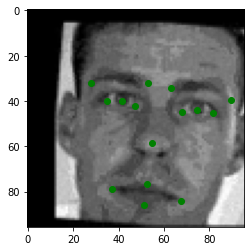

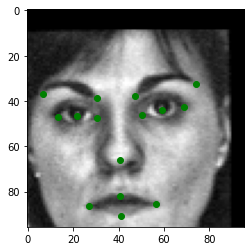

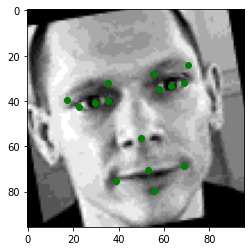

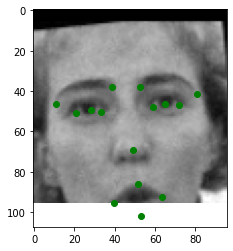

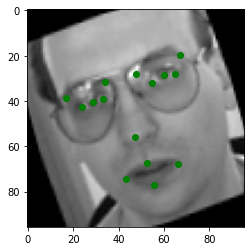

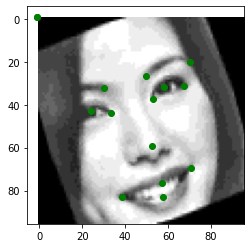

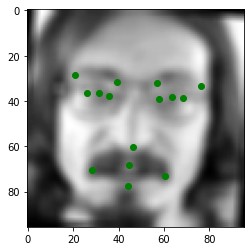

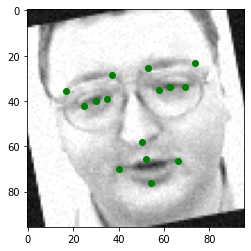

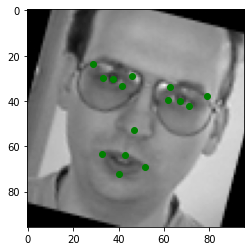

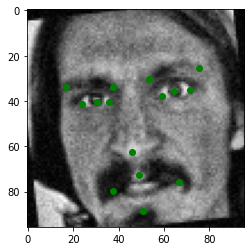

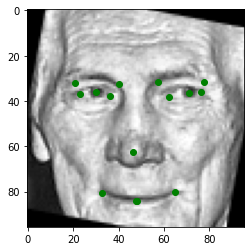

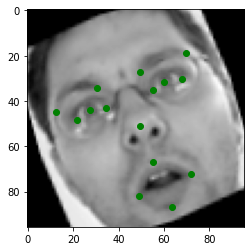

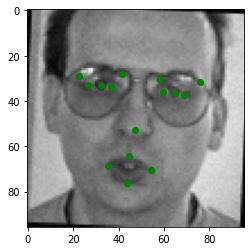

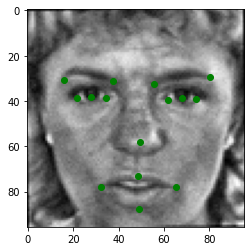

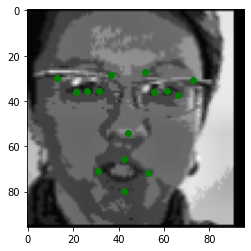

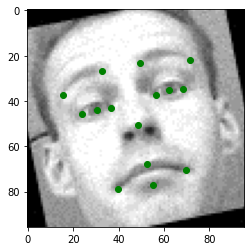

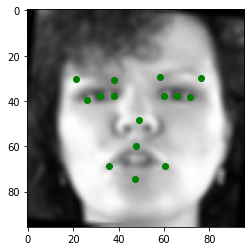

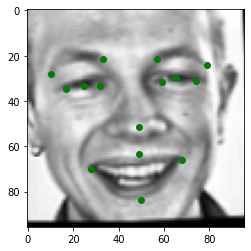

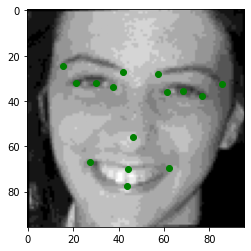

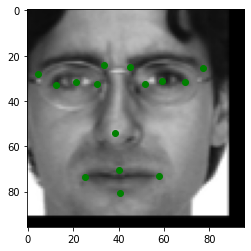

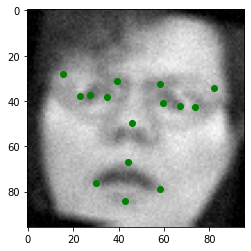

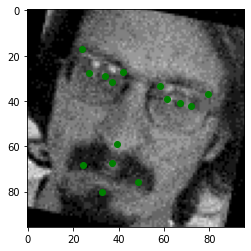

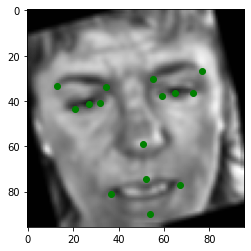

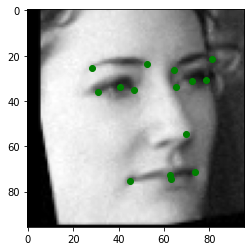

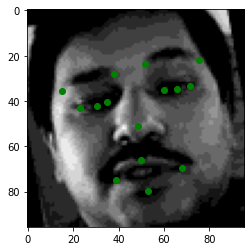

KeyboardInterrupt: ignored

In [ ]:
#dataset

import pandas as pd
import numpy as np
# import config
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

class FacialKeypointDataset(Dataset):
    def __init__(self, csv_file, train=True, transform=None):
        super().__init__()
        self.data = pd.read_csv(csv_file)#, index_col = 0 | usecols=range(1, 32))
        self.category_names = ['left_eye_center_x',
          'left_eye_center_y',
          'right_eye_center_x',
          'right_eye_center_y',
          'left_eye_inner_corner_x',
          'left_eye_inner_corner_y',
          'left_eye_outer_corner_x',
          'left_eye_outer_corner_y',
          'right_eye_inner_corner_x',
          'right_eye_inner_corner_y',
          'right_eye_outer_corner_x',
          'right_eye_outer_corner_y',
          'left_eyebrow_inner_end_x',
          'left_eyebrow_inner_end_y',
          'left_eyebrow_outer_end_x',
          'left_eyebrow_outer_end_y',
          'right_eyebrow_inner_end_x',
          'right_eyebrow_inner_end_y',
          'right_eyebrow_outer_end_x',
          'right_eyebrow_outer_end_y',
          'nose_tip_x',
          'nose_tip_y',
          'mouth_left_corner_x',
          'mouth_left_corner_y',
          'mouth_right_corner_x',
          'mouth_right_corner_y',
          'mouth_center_top_lip_x',
          'mouth_center_top_lip_y',
          'mouth_center_bottom_lip_x',
          'mouth_center_bottom_lip_y'
          ]
        self.transform = transform        
        self.train = train        
        

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):              
        if self.train:
            image = np.array(self.data.iloc[index, 31].split()).astype(np.float32)
            labels = np.array(self.data.iloc[index, 1:31].tolist())
            labels[np.isnan(labels)] = -1
        else:
            image = np.array(self.data.iloc[index, 1].split()).astype(np.float32)
            labels = np.zeros(30)

        ignore_indices = labels == -1
        labels = labels.reshape(15, 2)

        if self.transform:
            image = np.repeat(image.reshape(96, 96, 1), 3, 2).astype(np.uint8)
            augmentations = self.transform(image=image, keypoints=labels)
            image = augmentations["image"]
            labels = augmentations["keypoints"]

        labels = np.array(labels).reshape(-1)
        labels[ignore_indices] = -1

        return image, labels.astype(np.float32)


if __name__ == "__main__":
    ds = FacialKeypointDataset(csv_file="train_15.csv", train=True, transform=train_transforms)
    loader = DataLoader(ds, batch_size=1, shuffle=True, num_workers=0)

    for idx, (x,y) in enumerate(loader):
        plt.imshow(x[0][0].detach().cpu().numpy(), cmap='gray')
        plt.plot(y[0][0::2].detach().cpu().numpy(), y[0][1::2].detach().cpu().numpy(), "go")
        plt.show()


In [ ]:
# utils

# import torch
import numpy as np
import pandas as pd
# import config
from tqdm import tqdm

def get_submission(loader, dataset, model_15, model_4):
    model_15.eval()
    model_4.eval()
    id_lookup = pd.read_csv("IdLookupTable.csv")
    predictions = []
    image_id = 1

    for image, label in tqdm(loader):
        image = image.to(DEVICE)
        preds_15 = torch.clip(model_15(image).squeeze(0), 0.0, 96.0)
        preds_4 = torch.clip(model_4(image).squeeze(0), 0.0, 96.0)
        feature_names = id_lookup.loc[id_lookup["ImageId"] == image_id]["FeatureName"]

        for feature_name in feature_names:
            feature_index = dataset.category_names.index(feature_name)
            if feature_names.shape[0] < 10:
                predictions.append(preds_4[feature_index].item())
            else:
                predictions.append(preds_15[feature_index].item())

        image_id += 1

    df = pd.DataFrame({"Rowid": np.arange(1, len(predictions)+1), "Location": predictions})
    df.to_csv("submission.csv", index=False)
    model_15.train()
    model_4.train()

def get_rmse(loader, model, loss_fn, device):
    model.eval()
    num_examples = 0
    losses = []
    for batch_idx, (data, targets) in enumerate(loader):
        data = data.to(device=device)
        targets = targets.to(device=device)

        #forwards
        scores = model(data)
        loss = loss_fn(scores[targets != 1], targets[targets != 1])
        num_examples += scores[targets != 1].shape[0]
        losses.append(loss.item())

    model.train()
    print(f"loss on val: {(sum(losses)/num_examples)**0.5}")


def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model, optimizer, lr):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [ ]:
#train

import torch
# from dataset import FacialKeypointDataset
from torch import nn, optim
import os
# import config
from torch.utils.data import DataLoader
from tqdm import tqdm
from efficientnet_pytorch import EfficientNet
# from utils import (
#     load_checkpoint,
#     save_checkpoint,
#     get_rmse,
#     get_submission
# )

def train_one_epoch(loader, model, optimizer, loss_fn, scaler, device):
    losses = []
    loop = tqdm(loader)
    num_examples = 0
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=device)
        targets = targets.to(device=device)

        #forward
        scores = model(data)
        scores[targets == -1] = -1
        loss = loss_fn(scores, targets)
        num_examples += torch.numel(scores[targets != -1])
        losses.append(loss.item())

        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Loss average over epoch: {(sum(losses)/num_examples)**0.5}")


def main():
    train_ds = FacialKeypointDataset(
        csv_file="train_15.csv",
        transform=train_transforms,
    )
    train_loader = DataLoader(
        train_ds,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
    )
    val_ds = FacialKeypointDataset(
        transform=val_transforms,
        csv_file="val_15.csv",
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=False,
    )
    test_ds = FacialKeypointDataset(
        csv_file="test.csv",
        transform=val_transforms,
        train=False
    )
    test_loader = DataLoader(
        test_ds,
        batch_size=1,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=False,
    )
    loss_fn = nn.MSELoss(reduction="sum")
    model = EfficientNet.from_pretrained("efficientnet-b0")
    model._fc = nn.Linear(1280, 30)
    model = model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scaler = torch.cuda.amp.GradScaler()

    model_4 = EfficientNet.from_pretrained("efficientnet-b0")
    model_4._fc = nn.Linear(1280, 30)
    model_15 = EfficientNet.from_pretrained("efficientnet-b0")
    model_15._fc = nn.Linear(1280, 30)
    model_4 = model_4.to(DEVICE)
    model_15 = model_15.to(DEVICE)

    if LOAD_MODEL and CHECKPOINT_FILE in os.listdir():
        # load_checkpoint(torch.load(CHECKPOINT_FILE), model, optimizer, LEARNING_RATE)
        load_checkpoint(torch.load("b0_4.pth.tar"), model_4, optimizer, LEARNING_RATE)
        load_checkpoint(torch.load("b0_15.pth.tar"), model_15, optimizer, LEARNING_RATE)

    get_submission(test_loader, test_ds, model_15, model_4)

    # for epoch in range(NUM_EPOCHS):
    #     get_rmse(val_loader, model, loss_fn, DEVICE)
    #     train_one_epoch(train_loader, model, optimizer, loss_fn, scaler, DEVICE)

    #     #get on validation
    #     if SAVE_MODEL:
    #         checkpoint = {
    #             "state_dict": model.state_dict(),
    #             "optimizer": optimizer.state_dict(),
    #         }
    #         save_checkpoint(checkpoint, filename=CHECKPOINT_FILE)

if __name__ == "__main__":
    main()


Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
=> Loading checkpoint
=> Loading checkpoint


100%|██████████| 1783/1783 [01:17<00:00, 22.93it/s]
